In [70]:
# Synchronizacja z dyskiem
from google.colab import drive
drive.mount("/content/drive")

%cd './drive/My Drive/Projekt/FashionMnist'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: './drive/My Drive/Projekt/FashionMnist'
/content/drive/My Drive/Projekt/FashionMnist


In [71]:
# Importy i sprawdzenie czy mamy CUDA
import torch
import torchvision

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
dev

'cuda:0'

In [72]:
# parameters = {"batch_size": 100,
#               "kernel_size": 3,
#               "padding": 1, # dla kernel_size = 3 nie zmieni wielkości obrazka
#               "C": 4,
#               "n_blocks": 4,
#               "channels": [1, 16, 64, 128, 256],
#               "lr": 0.02,
#               "patience": 2,
#               "factor": 0.1,
#               "n_epochs": 40,
#               "dropouts": [0, 0.1, 0.2, 0.2],
#               "drop_path": [0.15, 0.15, 0.15, 0.15],
#               "linear_size2": 64,
#               "name": "Fractal_v0.1"}
# Accuracy of the network on test images: 89.88 %

# parameters = {"batch_size": 100,
#               "kernel_size": 3,
#               "padding": 1, # dla kernel_size = 3 nie zmieni wielkości obrazka
#               "C": 4,
#               "n_blocks": 4,
#               "channels": [1, 16, 64, 128, 256],
#               "lr": 0.02,
#               "patience": 1,
#               "factor": 0.1,
#               "n_epochs": 30,
#               "dropouts": [0, 0.1, 0.1, 0.1],
#               "drop_path": [0.15, 0.15, 0.15, 0.15],
#               "linear_size2": 64,
#               "name": "Fractal_v0.2"}
# Accuracy of the network on test images: 90.39 %

# parameters = {"batch_size": 100,
#               "kernel_size": 3,
#               "padding": 1, # dla kernel_size = 3 nie zmieni wielkości obrazka
#               "C": 4,
#               "n_blocks": 4,
#               "channels": [1, 16, 64, 128, 256],
#               "lr": 0.02,
#               "patience": 1,
#               "factor": 0.1,
#               "n_epochs": 30,
#               "dropouts": [0, 0.1, 0.1, 0.1],
#               "drop_path": [0.15, 0.15, 0.15, 0.15],
#               "name": "Fractal_v0.3"}
# 29 loss: 0.212 train accuracy: 93.16 % 
# Accuracy of the network on test images: 90.77 %

# parameters = {"batch_size": 100,
#               "kernel_size": 3,
#               "padding": 1, # dla kernel_size = 3 nie zmieni wielkości obrazka
#               "C": 4,
#               "n_blocks": 4,
#               "channels": [1, 8, 64, 128, 256],
#               "lr": 0.02,
#               "patience": 1,
#               "factor": 0.1,
#               "n_epochs": 30,
#               "dropouts": [0, 0.1, 0.1, 0.1],
#               "drop_path": [0.15, 0.15, 0.15, 0.15],
#               "name": "Fractal_v0.4"}
# Accuracy of the network on test images: 89.47 %

# parameters = {"batch_size": 100,
#               "kernel_size": 3,
#               "padding": 1, # dla kernel_size = 3 nie zmieni wielkości obrazka
#               "C": 4,
#               "n_blocks": 4,
#               "channels": [1, 16, 64, 128, 256],
#               "lr": 0.02,
#               "patience": 1,
#               "factor": 0.1,
#               "n_epochs": 35,
#               "dropouts": [0, 0.1, 0.1, 0.2],
#               "drop_path": [0.15, 0.15, 0.15, 0.15],
#               "name": "Fractal_v0.31"}
# Accuracy of the network on test images: 91.25 %
# 32 loss: 0.225 train accuracy: 92.29 %

# parameters = {"batch_size": 100,
#               "kernel_size": 3,
#               "padding": 1, # dla kernel_size = 3 nie zmieni wielkości obrazka
#               "C": 4,
#               "n_blocks": 4,
#               "channels": [1, 16, 64, 128, 256],
#               "lr": 0.02,
#               "patience": 1,
#               "factor": 0.1,
#               "n_epochs": 40,
#               "dropouts": [0, 0.1, 0.1, 0.2],
#               "drop_path": [0.15, 0.15, 0.15, 0.15],
#               "name": "Fractal_v0.32"}
# Accuracy of the network on test images: 91.20 %
# 31 loss: 0.216 train accuracy: 92.65 %
parameters = {"batch_size": 200,
              "kernel_size": 3,
              "padding": 1, # dla kernel_size = 3 nie zmieni wielkości obrazka
              "C": 4,
              "n_blocks": 4,
              "channels": [1, 16, 64, 128, 256],
              "lr": 0.02,
              "patience": 1,
              "factor": 0.1,
              "n_epochs": 30,
              "dropouts": [0, 0.1, 0.1, 0.15],
              "drop_path": [0.1, 0.1, 0.1, 0.1],
              "name": "Fractal_v0.311"}

In [73]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Katalog, w którym przechowujemy dane
root = "data"
batch_size = parameters["batch_size"]

# Transformacje wektorów wejściowych
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))])

#ładowanie danych
train_dataset = dsets.FashionMNIST(root=root,
                            train=True,
                            transform=transform,
                            download=True)

test_dataset = dsets.FashionMNIST(root=root,
                            train=False,
                            transform=transform)

trainloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                batch_size=batch_size,
                                                shuffle=True)

testloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                batch_size=batch_size,
                                                shuffle=True) 

In [74]:
import torch.nn as nn
import torch.nn.functional as F

In [75]:
kernel_size = parameters["kernel_size"]
padding = parameters["padding"]

In [76]:
import numpy as np

class DropPath(nn.Module):
  # Klasa implementująca drop-path opisany w pracy (dział 3.1)
  # Z tym samym prawdopodobiestwem wybierana jest strategia
  # "Local" i "Global"

  # Parametr `p` określa prawdopodobieństwo, z jakim każdy z inputów
  # będzie odrzucony, przy czym przynajmniej jedna ze ścieżek musi zostać
  # wybrana. Parametr jest wykorzystywany jedynie w strategii "Local"
  # `C` oznacza liczbę kolumn w jednym bloku sieci Fractal
  def __init__(self, p, C):
    super(DropPath, self).__init__()
    self.C = C
    self.p = p

  def prepare(self):
    self.is_global = np.random.choice([True, False])
    if self.is_global:
      self.allowed = np.random.choice(np.arange(1, self.C + 1))

  def forward(self, x, column = None):
    if not self.training:
      return x
    if self.is_global:
      if column == self.allowed:
        return x
      else:
        return torch.zeros_like(x)
    if np.random.random() < self.p:
      return torch.zeros_like(x)
    return x

In [77]:
'''
Szczegóły implementacji są w dziale 3.3.
* "As now standard, we employ batch normalization together with each conv layer 
  (convolution, batch norm, then ReLU)."
'''

class Fractal(nn.Module):
  # Klasa implementuje blok "f_C" z pracy (dział 3)

  # parametr `n_channels` określa liczbę kanałów pomiędzy
  # kolejnymi `f_i`; np dla C = 1 mamy
  # n_channels = [in_channels, out_channels]
  # dropPath - instancja klasy DropPath w bloku, do którego należy Fractal
  def __init__(self, C, in_channels, out_channels, dropPath, dropout):
    super(Fractal, self).__init__()
    self.C = C
    self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
    self.bn2d = nn.BatchNorm2d(out_channels)
    self.dropPath = dropPath
    self.dropout = nn.Dropout2d(dropout)

    if C > 1:
      self.fC1 = Fractal(C - 1, in_channels, out_channels, dropPath, dropout)
      self.fC2 = Fractal(C - 1, out_channels, out_channels, dropPath, dropout)
    
  def forward(self, x):
    x1 = self.dropPath(F.relu(self.bn2d(self.conv2d(x))), self.C)
    x1 = self.dropout(x1)
    if self.C > 1:
      x2 = self.fC2(self.fC1(x))
      x1 = torch.mean(torch.stack([x1, x2]), 0) # join
    return x1

In [78]:
class Block(nn.Module):
  # Klasa implementuje budowę bloku, oraz zawiera w sobie rekurencyjne
  # tworzenie kolejnego

  # C jest parametrem określającym liczbę kolumn w danym bloku
  # n_block oznacza numer bloku (ten na samym dole na numer 0)
  # channels określa liczbę kanałów kolejno wejściowych i wyjściowych
  #   każdego bloku
  def __init__(self, C, n_block, channels, p, dropouts):
    super(Block, self).__init__()

    self.dropPath = DropPath(p[0], C)
    self.fractal = Fractal(C, channels[0], channels[1], self.dropPath, dropouts[0])
    self.n_block = n_block
    
    if self.n_block > 0:
      self.next_block = Block(C, n_block - 1, channels[1:], p[1:], dropouts[1:])

    self.pool = nn.MaxPool2d(2, 2)

  def forward(self, x):
    self.dropPath.prepare()
    x = self.pool(self.fractal(x))
    if self.n_block > 0:
      x = self.next_block(x)
    return x

In [79]:
class FractalNet(nn.Module):
  # C jest parametrem określającym liczbę kolumn w danym bloku
  # n_blocks oznacza liczbę bloków
  # channels określa liczbę kanałów kolejno wejściowych i wyjściowych
  #   każdego bloku
  # len(channels) = n_blocks + 1
  def __init__(self, C, n_blocks, channels, droppath_p, dropouts):
    super(FractalNet, self).__init__()

    if len(channels) != n_blocks + 1:
      raise RuntimeError("Niepoprawny rozmiar tablicy `channels`.")
    if len(droppath_p) != n_blocks:
      raise RuntimeError("Niepoprawny rozmiar tablicy `droppath_p`.")

    self.block = Block(C, n_blocks - 1, channels, droppath_p, dropouts)

    image_size = 28
    output_size = int(image_size / int(2 ** n_blocks))
    self.linearSize1 = (output_size ** 2) * channels[-1]

    self.dense1 = nn.Linear(self.linearSize1, 10)

  def forward(self, x):
    x = self.block(x)
    x = x.view(-1, self.linearSize1)
    x = self.dense1(x)
    return x

In [80]:
net = FractalNet(parameters["C"], 
                 parameters["n_blocks"], 
                 parameters["channels"], 
                 parameters["drop_path"],
                 parameters["dropouts"])
# jeżeli można, używamy CUDA
if torch.cuda.is_available():
  net.to("cuda:0")

In [81]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=parameters["lr"], momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=parameters["factor"],
                              patience=parameters["patience"], verbose=True)


def accuracy(model, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in dataloader:
          images, labels = data
          if torch.cuda.is_available():
            images = images.to("cuda:0")
            labels = labels.to("cuda:0")
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return 100 * correct / total

In [82]:
save_path = "saved_models/" + parameters["name"]

In [83]:
n_epochs = parameters["n_epochs"]
best_accuracy = 0
results = []

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    running_loss_n = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if torch.cuda.is_available():
          inputs = inputs.to("cuda:0")
          labels = labels.to("cuda:0")


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_loss_n += 1
    epoch_accuracy = accuracy(net, trainloader)
    results.append((epoch + 1, running_loss / running_loss_n, epoch_accuracy))
    print('%d loss: %.3f train accuracy: %.2f %%' %
                   (epoch + 1, running_loss / running_loss_n, 
                    epoch_accuracy))
    scheduler.step(epoch_accuracy)

    if best_accuracy < epoch_accuracy:
      best_accuracy = epoch_accuracy
      torch.save((net.state_dict(), results), save_path)

print('Finished Training')

1 loss: 1.332 train accuracy: 72.52 %
2 loss: 0.668 train accuracy: 79.78 %
3 loss: 0.530 train accuracy: 82.55 %
4 loss: 0.451 train accuracy: 84.19 %
5 loss: 0.399 train accuracy: 85.72 %
6 loss: 0.382 train accuracy: 86.50 %
7 loss: 0.373 train accuracy: 86.85 %
8 loss: 0.384 train accuracy: 87.10 %
9 loss: 0.335 train accuracy: 87.98 %
10 loss: 0.319 train accuracy: 88.28 %
11 loss: 0.301 train accuracy: 89.00 %
12 loss: 0.289 train accuracy: 88.57 %
13 loss: 0.289 train accuracy: 89.97 %
14 loss: 0.283 train accuracy: 90.04 %
15 loss: 0.266 train accuracy: 90.07 %
16 loss: 0.268 train accuracy: 89.91 %
17 loss: 0.254 train accuracy: 90.56 %
18 loss: 0.248 train accuracy: 90.87 %
19 loss: 0.240 train accuracy: 91.25 %
20 loss: 0.236 train accuracy: 91.43 %
21 loss: 0.230 train accuracy: 91.65 %
22 loss: 0.230 train accuracy: 91.66 %
23 loss: 0.225 train accuracy: 91.98 %
24 loss: 0.220 train accuracy: 92.29 %
25 loss: 0.216 train accuracy: 92.03 %
26 loss: 0.232 train accuracy: 91.

In [84]:
params, results = torch.load(save_path)
net.load_state_dict(params)
print('Accuracy of the network on test images: %.2f %%' % (
    accuracy(net, testloader)))

Accuracy of the network on test images: 91.36 %


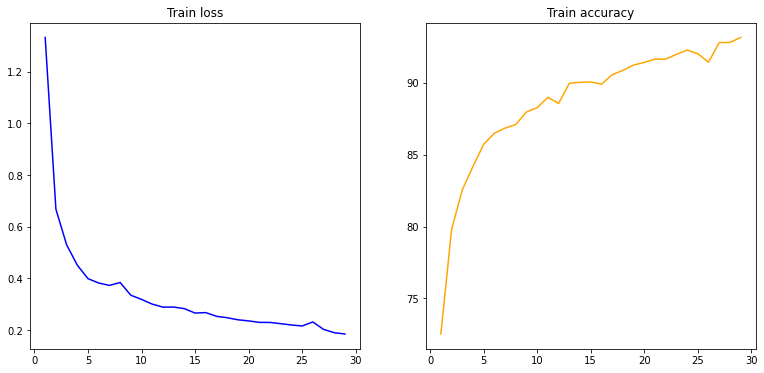

In [85]:
import matplotlib.pyplot as plt

epoch, loss, acc = tuple(zip(*results))

fig = plt.figure(figsize=(13, 6))
ax = fig.add_subplot(121) 
ax.plot(epoch, loss, c="blue", label="loss")
ax.set_title("Train loss")
ax = fig.add_subplot(122)
ax.plot(epoch, acc, c="orange", label="accuracy")
ax.set_title("Train accuracy")
plt.show()